In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
from data import proteomeHD_df
from util import read_json_from, write_json_to, calc_eta
from visualization_util import df_roc_analysis,df_precision_recall_analysis
from validation import validate_relations_in_df,full_report_calculation_by_size,simplifed_report_df,is_corum_verifiable
import seaborn as sns
import matplotlib.pyplot as plt
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")
RANDOM_STATE = 0

# Constructing Datasets

In [2]:
proHD_ratios_min95_path = f"{PATH_ROOT}/data_sources/ProteomeHD/proHD_ratios_min95.csv"
proHD_ratios_min95_df = pd.read_csv(proHD_ratios_min95_path)
proHD_cols = [col for col in proHD_ratios_min95_df.columns if 'Ratio' in col]
coreg_score_lookup = read_json_from(f"{PATH_ROOT}/data_sources/ProteomeHD/coregulation_scores_simplified_lookup.json")

In [3]:
from sklearn.model_selection import train_test_split
sampled_proteins_df = proHD_ratios_min95_df.sample(600,random_state=RANDOM_STATE)
train_proteins_df,test_proteins_df = train_test_split(sampled_proteins_df,test_size=0.33,random_state=RANDOM_STATE)
train_proteins_df = train_proteins_df.copy()
test_proteins_df = test_proteins_df.copy()
mixed_proteins_df = pd.concat([train_proteins_df.sample(100,random_state=RANDOM_STATE),test_proteins_df])

In [4]:
def construct_combined_pairs_df(df):
    proteins = df['Simplified_protein_ID'].to_numpy()
    feature_matrix = df[proHD_cols].fillna(0).to_numpy()
    lookup = {p:idx for idx,p in enumerate(proteins)}
    corr_mat = df[proHD_cols].transpose().corr().to_numpy()
    proHD_cols_1 = [col+'_1' for col in proHD_cols]
    proHD_cols_2 = [col+'_2' for col in proHD_cols]
    feature_columns = ['combined_name','protein_1','protein_2','pearson','coregulation_score'] + proHD_cols_1 + proHD_cols_2
    rows = []
    for i in range(len(proteins)):
        for j in range(i,len(proteins)):
            if i!=j:
                p1,p2 = proteins[i],proteins[j]
                vec1,vec2 = feature_matrix[lookup[p1]],feature_matrix[lookup[p2]]
                comb_name = p1+'-'+p2
                #comb_vec = vec1+vec2
                comb_vec = np.concatenate((vec1,vec2))
                pearson = corr_mat[i][j]
                coregulation = coreg_score_lookup[p1][p2]
                row = [comb_name,p1,p2,pearson,coregulation] + comb_vec.tolist()
                rows.append(row)
    to_return = pd.DataFrame(data=rows,columns=feature_columns)
    return to_return    

In [5]:
from validation import validate_relations_in_df
training_pairs = construct_combined_pairs_df(train_proteins_df)
training_pairs = validate_relations_in_df(training_pairs,timed=True)
training_pairs,c1_validation_pairs = train_test_split(training_pairs,test_size=0.2,random_state=RANDOM_STATE)
pos_binary_training_pairs = training_pairs[training_pairs['binary_interaction'] == 1]
pos_cocomplex_training_pairs = training_pairs[training_pairs['cocomplex'] == 1]
binary_training_pairs_downsampled = pd.concat([training_pairs[training_pairs['binary_interaction'] == 0].sample(len(pos_binary_training_pairs),random_state=RANDOM_STATE),pos_binary_training_pairs]).copy()
cocomplex_training_pairs_downsampled = pd.concat([training_pairs[training_pairs['cocomplex'] == 0].sample(len(pos_cocomplex_training_pairs),random_state=RANDOM_STATE),pos_cocomplex_training_pairs]).copy()

Current Index: 1, ETA: 173679.10413742065
Current Index: 10001, ETA: 52.34672870412849
Current Index: 20001, ETA: 31.5698759978154
Current Index: 30001, ETA: 21.25296669162745
Current Index: 40001, ETA: 16.211223484280676
Current Index: 50001, ETA: 10.905039376972775
Current Index: 60001, ETA: 7.1782395040247255
Current Index: 70001, ETA: 3.4718681469288684
Current Index: 80001, ETA: 0.20391679022011494


In [6]:
mixed_pairs = construct_combined_pairs_df(mixed_proteins_df)
train_proteins = set(np.union1d(training_pairs['protein_1'].to_numpy(),training_pairs['protein_2'].to_numpy()))
mixed_pairs_p1s = mixed_pairs['protein_1'].to_numpy()
mixed_pairs_p2s = mixed_pairs['protein_2'].to_numpy()
seen_in_train = [(mixed_pairs_p1s[i] in train_proteins) + (mixed_pairs_p2s[i] in train_proteins) for i in range(len(mixed_pairs_p1s))]
mixed_pairs['seen_in_train'] = seen_in_train
mixed_pairs = mixed_pairs[mixed_pairs['seen_in_train'] == 1].copy()
c2_validation_pairs = validate_relations_in_df(mixed_pairs,timed=True) 

Current Index: 10001, ETA: 1.6060268755686686
Current Index: 20001, ETA: -0.015890791001221424


In [7]:
c3_validation_pairs = construct_combined_pairs_df(test_proteins_df)
c3_validation_pairs = validate_relations_in_df(c3_validation_pairs,timed=True)

Current Index: 1, ETA: 4622.010973930359
Current Index: 10001, ETA: 1.8498913631261844


# Preparing Datasets

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split

# For reproducibility
torch.manual_seed(RANDOM_STATE)

class TabularDataset(Dataset):
    def __init__(self,df,feature_cols,label_col):
        self.df = df
        self.features = torch.as_tensor(df[feature_cols].to_numpy()).float()
        self.labels = torch.as_tensor(df[label_col].to_numpy())
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        return self.features[index],self.labels[index]

proHD_cols_1 = [col+'_1' for col in proHD_cols]
proHD_cols_2 = [col+'_2' for col in proHD_cols]
proHD_cols_comb = proHD_cols_1 + proHD_cols_2
proHD_stratified_binary_train_dataset = TabularDataset(binary_training_pairs_downsampled,proHD_cols_comb,'binary_interaction')    
proHD_stratified_cocomplex_train_dataset = TabularDataset(cocomplex_training_pairs_downsampled,proHD_cols_comb,'cocomplex')

proHD_unstratified_binary_train_dataset = TabularDataset(training_pairs,proHD_cols_comb,'binary_interaction') 
proHD_unstratified_cocomplex_train_dataset = TabularDataset(training_pairs,proHD_cols_comb,'cocomplex') 

# Adopting C1,C2,C3 testing from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3531800/
proHD_c1_test_dataset = TabularDataset(c1_validation_pairs,proHD_cols_comb,'cocomplex')
proHD_c2_test_dataset = TabularDataset(c2_validation_pairs,proHD_cols_comb,'cocomplex')
proHD_c3_test_dataset = TabularDataset(c3_validation_pairs,proHD_cols_comb,'cocomplex')


# proteomeHD_combined_pairs_df = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_balanced_pos_neg_pairs_combined.csv")
# proHD_cols = [col for col in proteomeHD_combined_pairs_df.columns if 'Ratio' in col]
# train_df,test_df = train_test_split(proteomeHD_combined_pairs_df,test_size=0.2,random_state=RANDOM_STATE)

# train_proteins = set(np.union1d(train_df['protein_1'].to_numpy(),train_df['protein_2'].to_numpy()))
# test_p1s = test_df['protein_1'].to_numpy()
# test_p2s = test_df['protein_2'].to_numpy()
# seen_in_train = [(test_p1s[i] in train_proteins) + (test_p2s[i] in train_proteins) for i in range(len(test_p1s))]
# test_df_copy = test_df.copy()
# test_df_copy['seen_in_train'] = seen_in_train

# proHD_stratified_train_dataset = TabularDataset(train_df,proHD_cols,'cocomplex')
# proHD_stratified_test_dataset = TabularDataset(test_df_copy,proHD_cols,'cocomplex')

# Data loader

# BATCH_SIZE = 64

# train_loader = torch.utils.data.DataLoader(dataset=proHD_stratified_binary_train_dataset, 
#                                            batch_size=BATCH_SIZE, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=proHD_stratified_test_dataset, 
#                                           batch_size=BATCH_SIZE, 
#                                           shuffle=False)

# Define model architecture & hyperparameters

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters & Data Loader
learning_rate = 1e-3
num_epochs = 100
batch_size = 64
dropout_prob = 0.5
#weights = [0.01, 1.0]
BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(dataset=proHD_stratified_cocomplex_train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
# 
# Architecture
num_features = 588
hidden_layer_1_size = 512
hidden_layer_2_size = 512
num_classes = 2

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultilayerPerceptron, self).__init__()
        # Input -> First Hidden Layer
        self.linear_1 = nn.Linear(input_size, hidden_layer_1_size)
        self.linear_1_bn = torch.nn.BatchNorm1d(hidden_layer_1_size)
        # First Hidden Layer -> Second Hidden Layer
        self.linear_2 = nn.Linear(hidden_layer_1_size, hidden_layer_2_size)
        self.linear_2_bn = torch.nn.BatchNorm1d(hidden_layer_2_size)
        # Second Hidden Layer -> Output layer
        self.linear_out = nn.Linear(hidden_layer_2_size, output_size)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_1_bn(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        logits = self.linear_out(out)
        # probas = F.log_softmax(logits, dim=1)
        return logits
    
model = MultilayerPerceptron(input_size=num_features,output_size=num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#class_weights = torch.FloatTensor(weights).cuda()
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

# Train the model

In [10]:
model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(features)

        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Evaluate model

In [50]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy on test set: {} %'.format(100 * correct / total))

Accuracy on test set: 97.65 %


In [11]:
# Have the model make prediction on test set
positive_prob = None
with torch.no_grad():
#     features = proHD_stratified_test_dataset.features.to(device)
    features = proHD_c1_test_dataset.features.to(device)
    outputs = model(features)
    class_prob = F.softmax(outputs,dim=1)
    positive_prob = class_prob[:,1].cpu().numpy()

In [12]:
summary_df = c1_validation_pairs[['protein_1','protein_2','coregulation_score','pearson','binary_interaction','cocomplex']].copy()
summary_df['mlp_score'] = positive_prob

In [205]:
# # Compare probability to coregulation score using ROC and PRC
# summary_df = test_df[['protein_1','protein_2','coregulation_score','pearson','binary_interaction','cocomplex']].copy()
# summary_df['mlp_score'] = positive_prob

In [13]:
scores_to_check = ['coregulation_score','pearson','mlp_score']

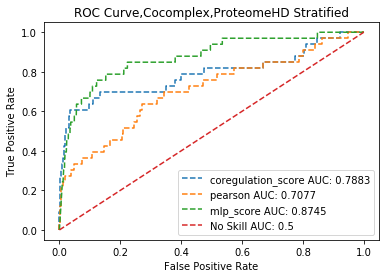

[0.7883854708195833, 0.7077494236246101, 0.8745705438271325, 0.5]

In [14]:
df_roc_analysis(summary_df,scores_to_check,'cocomplex','ROC Curve,Cocomplex,ProteomeHD Stratified')

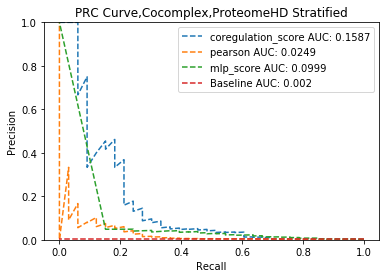

[0.15875006630600583,
 0.02499685594205009,
 0.09996539045964765,
 0.0020470194156690033]

In [15]:
df_precision_recall_analysis(summary_df,scores_to_check,'cocomplex','PRC Curve,Cocomplex,ProteomeHD Stratified',ylim=(0,1),legend_placement='best')

# Evaluate model on unstratified dataset

In [16]:
proHD_unstratified_test_df = pd.read_csv(f"{PATH_ROOT}/data_sources/ProteomeHD/proteomeHD_unstratified_pairs_combined.csv")

In [17]:
# Remove seen interactions from train
proHD_unstratified_test_df = proHD_unstratified_test_df[~proHD_unstratified_test_df.combined_name.isin(proteomeHD_combined_pairs_df['combined_name'])]
np.sum(proHD_unstratified_test_df['cocomplex'].to_numpy())

182

In [56]:
proHD_unstratified_test_dataset = TabularDataset(proHD_unstratified_test_df,proHD_cols,'binary_interaction')

In [57]:
# Have the model make prediction on test set
# TODO: rewrite as method
positive_prob = None
with torch.no_grad():
    features = proHD_unstratified_test_dataset.features.to(device)
    outputs = model(features)
    class_prob = F.softmax(outputs,dim=1)
    positive_prob = class_prob[:,1].cpu().numpy()

In [58]:
# Compare probability to coregulation score using ROC and PRC
summary_df = proHD_unstratified_test_df[['protein_1','protein_2','pearson','coregulation_score','binary_interaction','cocomplex']].copy()
summary_df['mlp_score'] = positive_prob
summary_df = summary_df.dropna()

In [59]:
np.sum(np.isnan(summary_df['pearson'].to_numpy()))

0

In [60]:
scores_to_check = ['coregulation_score','pearson','mlp_score']

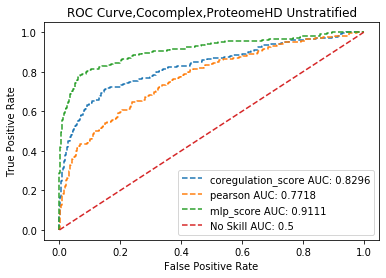

[0.8296397506841424, 0.7718203820319874, 0.9111696545462517, 0.5]

In [61]:
df_roc_analysis(summary_df,scores_to_check,'cocomplex','ROC Curve,Cocomplex,ProteomeHD Unstratified')

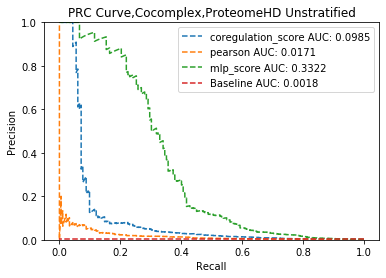

[0.0985477931822674,
 0.01710521427251827,
 0.33222053878218416,
 0.0018349178823837801]

In [62]:
df_precision_recall_analysis(summary_df,scores_to_check,'cocomplex','PRC Curve,Cocomplex,ProteomeHD Unstratified',ylim=(0,1),legend_placement='best')